# Hyper-study

The time series models built with the help of *bayesloop* are called [hierarchical models](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling), since the parameters of the observation model are in turn controlled by hyper-parameters that are possibly included in the transition model. In the [previous section](hyperparameteroptimization.html), we optimized two hyper-parameters of a serially combined transition model: the slope of the decrease in coal mining disasters from 1885 to 1895, and the magnitude of the fluctuations afterwards. While the optimization routine yields the most probable values of these hyper-parameters, one might also be interested in the uncertainty tied to these *"optimal"* values. *bayesloop* therefore provides the `HyperStudy` class that allows to compute the full distribution of hyper-parameters by defining a discrete grid of hyper-parameter values.

While the `HyperStudy` instance can be configured just like a standard `Study` instance, one may supply not only single hyper-parameter values, but also lists/arrays of values. Here, we test a range on hyper-parameter values by supplying regularly spaced hyper-parameter values using the `cint` function (one can of course also use similar functions like [numpy.linspace](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)). In the example below, we return to the serial transition model used [here](hyperparameteroptimization.html#Global-optimization) and compute a two-dimensional distribution of the two hyper-parameters `slope` (20 steps from -0.4 to 0.0) and `sigma` (20 steps from 0.0 to 0.8).

After running the fit-method for all value-tuples of the hyper-grid, the model evidence values of the individual fits are used as weights to compute weighted average parameter distributions. These average parameter distributions allow to assess the temporal evolution of the model parameters, explicitely considering the uncertainty of the hyper-parameters. However, in case one is only interested in the hyper-parameter distribution, setting the keyword-argument `evidenceOnly=True` of the `fit` method shortens the computation time but skips the evaluation of parameter distributions.

Finally, *bayesloop* provides several methods to plot the results of the hyper-study. To display the joint distribution of two hyper-parameters, choose `getJointHyperParameterDistribution`. The method automatically computes the [marginal distribution](https://en.wikipedia.org/wiki/Marginal_distribution) for the two specified hyper-parameters and returns three arrays, two for the hyper-parameters values and one with the corresponding probability (density) values. Here, the first argument (keyword `params`) represents a list of two hyper-parameter names, or simply two indices. By default, the first two hyper-parameters will be used. If the keyword-argument `plot=True` is set, a visualization is created using the `bar3d` function from the [mpl_toolkits.mplot3d](http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html) module.

+ Created new study.
  --> Hyper-study
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident rate']
+ Transition model: Serial transition model. Hyper-Parameter(s): ['slope', 'sigma', 't_1', 't_2']
+ Started new fit.
+ Set hyper-prior(s): ['flat', 'flat', 'flat', 'flat']
    + 400 analyses to run.

    + Computed average posterior sequence
    + Log10-evidence of average model: -73.47969
    + Computed hyper-parameter distribution
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


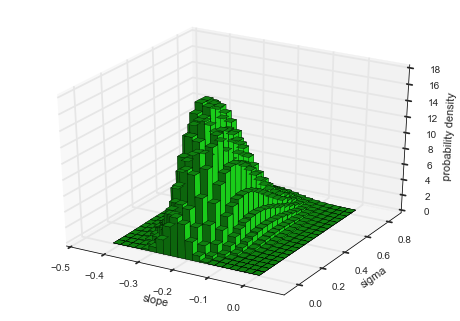

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

import numpy as np
import bayesloop as bl

S = bl.HyperStudy()
S.loadExampleData()
S.setObservationModel(bl.om.Poisson('accident rate', bl.oint(0, 6, 1000)))

T = bl.tm.SerialTransitionModel(bl.tm.Static(),
                                bl.tm.BreakPoint('t_1', 1885),
                                bl.tm.Deterministic(lambda t, slope=bl.cint(-0.4, 0, 20): slope*t, 
                                                    target='accident rate'),
                                bl.tm.BreakPoint('t_2', 1895),
                                bl.tm.GaussianRandomWalk('sigma', bl.cint(0, 0.8, 20), 
                                                         target='accident rate'))
S.setTransitionModel(T)

S.fit()
S.getJointHyperParameterDistribution(['slope', 'sigma'], plot=True, color=[0.1, 0.8, 0.1])

plt.xlim([-0.5, 0.1])
plt.ylim([-0.1, 0.9]);

It is important to note here, that the evidence value of $\approx 10^{-73.5}$ is smaller compared to the value of $\approx 10^{-72.7}$ obtained in a previous analysis [here](hyperparameteroptimization.html#Global-optimization). There, we optimized the hyper-parameter values and assumed that these optimal values are not subject to uncertainty, therefore over-estimating the model evidence. In contrast, the hyper-study explicitely considers the uncertainty tied to the hyper-parameter values.

While the joint distribution of two hyper-parameters may uncover possible correlations between the two quantities, the 3D plot is often difficult to integrate into existing figures. `HyperStudy` therefore also provides the method `getHyperParameterDistribution` that computes (and plots) the marginal distribution of a single hyper-parameter in a simple 2D histogram/bar plot:

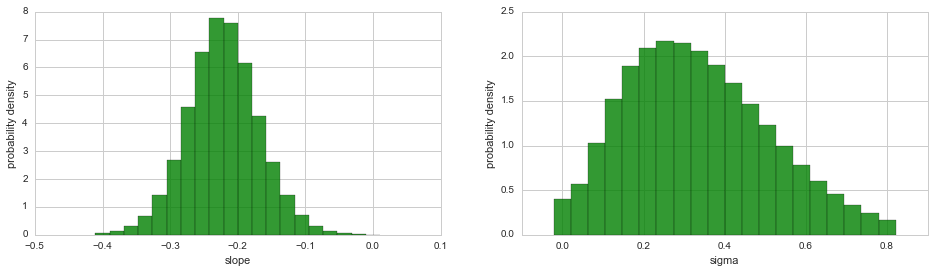

In [2]:
plt.figure(figsize=(16,4))
plt.subplot(121)
S.getHyperParameterDistribution('slope', plot=True, color='g', alpha=.8);

plt.subplot(122)
S.getHyperParameterDistribution('sigma', plot=True, color='g', alpha=.8);

Finally, the temporal evolution of the model parameters may be displayed using `plotParameterEvolution`:

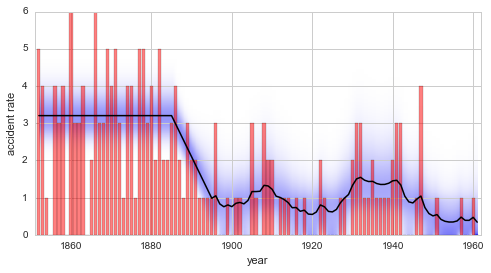

In [3]:
plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1851, 1962])
plt.xlabel('year')

In principle, a `HyperStudy` could also be used to test different time stamps for change- and break-points. However, in a transition model with several change- or break-points, the correct order has to be maintained. Since a `HyperStudy` fits all possible combinations of hyper-parameter values, we need another type of study that takes care of the correct order of change-/break-points, the `ChangepointStudy` class. It is introduced in [the next tutorial](changepointstudy.html).